# MLJ Demo from the June 2019 MLJ/sktime Sprint

### Load environment and seed RNG

In [57]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using Random
Random.seed!(1234);

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


## 1. Basics

### Constructing a task

In [58]:
using MLJ
models()

Dict{Any,Any} with 9 entries:
  "MultivariateStats" => Any["RidgeRegressor", "PCA"]
  "MLJ"               => Any["MLJ.Constant.DeterministicConstantRegressor", "ML…
  "DecisionTree"      => Any["DecisionTreeRegressor", "DecisionTreeClassifier"]
  "ScikitLearn"       => Any["SVMLRegressor", "SVMNuClassifier", "ElasticNet", …
  "LIBSVM"            => Any["EpsilonSVR", "LinearSVC", "NuSVR", "NuSVC", "SVC"…
  "Clustering"        => Any["KMeans", "KMedoids"]
  "GLM"               => Any["OLSRegressor", "GLMCountRegressor"]
  "NaiveBayes"        => Any["GaussianNBClassifier", "MultinomialNBClassifier"]
  "XGBoost"           => Any["XGBoostCount", "XGBoostRegressor", "XGBoostClassi…

In [59]:
using RDatasets
boston = dataset("MASS", "Boston");
first(boston)

,Crim,Zn,Indus,Chas,NOx,Rm,Age,Dis,Rad,Tax
,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Int64
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296


In [60]:
scitypes(boston)

(Crim = Continuous,
 Zn = Continuous,
 Indus = Continuous,
 Chas = Count,
 NOx = Continuous,
 Rm = Continuous,
 Age = Continuous,
 Dis = Continuous,
 Rad = Count,
 Tax = Count,
 PTRatio = Continuous,
 Black = Continuous,
 LStat = Continuous,
 MedV = Continuous,)

In [61]:
task = supervised(data=boston,
                  target=:MedV,
                  ignore=:Chas,
                  types=Dict(:Rad=>Continuous,:Tax=>Continuous),
                  is_probabilistic=false)
shuffle!(task)

┌ Info: 
│ is_probabilistic = false
│ input_scitype_union = Continuous 
│ target_scitype_union = Continuous
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/dwOtA/src/tasks.jl:104


SupervisedTask @ 1…17


In [62]:
models(task)

Dict{Any,Any} with 6 entries:
  "MultivariateStats" => Any["RidgeRegressor"]
  "MLJ"               => Any["MLJ.Constant.DeterministicConstantRegressor", "ML…
  "DecisionTree"      => Any["DecisionTreeRegressor"]
  "ScikitLearn"       => Any["SVMLRegressor", "ElasticNet", "ElasticNetCV", "SV…
  "LIBSVM"            => Any["EpsilonSVR", "NuSVR"]
  "XGBoost"           => Any["XGBoostRegressor"]

In [63]:
task.is_probabilistic=true
models(task)

Dict{Any,Any} with 2 entries:
  "MLJ" => Any["OLSRegressor", "ConstantRegressor"]
  "GLM" => Any["OLSRegressor"]

### Binding a task to a model

In [64]:
@load OLSRegressor
model = OLSRegressor()

┌ Info: A model named "OLSRegressor" is already loaded.
│ Nothing new loaded. 
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/loading.jl:195


OLSRegressor(fit_intercept = true,) @ 1…91

In [65]:
mach = machine(model, task)

Machine{OLSRegressor} @ 1…65


### Evaluation

In [66]:
evaluate!(mach, resampling=CV(nfolds=5), measure=rms)

┌ Info: Evaluating using cross-validation. 
│ nfolds=5. 
│ shuffle=false 
│ measure=MLJ.rms 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/resampling.jl:137
Cross-validating: 100%[=========================] Time: 0:00:02


5-element Array{Float64,1}:
 4.426958694375924
 4.073491300934762
 4.025520665431873
 7.065249969947815
 4.944588745640606

### Fitting

In [67]:
train, test = partition(1:nrows(task), 0.7)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  345, 346, 347, 348, 349, 350, 351, 352, 353, 354], [355, 356, 357, 358, 359, 360, 361, 362, 363, 364  …  497, 498, 499, 500, 501, 502, 503, 504, 505, 506])

In [68]:
fit!(mach, rows=train)

┌ Info: Training Machine{OLSRegressor} @ 1…65.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/machines.jl:135


Machine{OLSRegressor} @ 1…65


### Predicting on training data

In [69]:
yhat = predict(mach, rows=train);
yhat = predict(mach, task[train]);
yhat[1:3]

3-element Array{Distributions.Normal{Float64},1}:
 Distributions.Normal{Float64}(μ=25.043372128264604, σ=4.623657903357559)
 Distributions.Normal{Float64}(μ=0.5226442781772036, σ=4.623657903357559)
 Distributions.Normal{Float64}(μ=21.925933462643716, σ=4.623657903357559)

In [70]:
y = task[train].y;
y[1:3]

3-element Array{Float64,1}:
 22.2
 13.8
 22.0

In [71]:
rms(yhat, y)

4.5379661535101015

### Predicting on "new" data

In [72]:
X = task[test].X;
yhat = predict(mach, X);
yhat[1:4]

4-element Array{Distributions.Normal{Float64},1}:
 Distributions.Normal{Float64}(μ=28.015633122550412, σ=4.623657903357559)
 Distributions.Normal{Float64}(μ=22.64694885294991, σ=4.623657903357559) 
 Distributions.Normal{Float64}(μ=20.58349588465976, σ=4.623657903357559) 
 Distributions.Normal{Float64}(μ=15.956155864285499, σ=4.623657903357559)

### Specicial to probabilistic models

In [73]:
mean.(yhat[1:4])

4-element Array{Float64,1}:
 28.015633122550412
 22.64694885294991 
 20.58349588465976 
 15.956155864285499

In [74]:
mean.(yhat) == predict_mean(mach, X)

true

In [75]:
import Distributions
[Distributions.cdf(d, 10.0) for d in yhat[1:4]]

4-element Array{Float64,1}:
 4.881600290149807e-5 
 0.0031164643632286275
 0.01104003468974879  
 0.09883969064710876  

## 2. Random Forests - Case Study in Ensembling and Tuning

### Quick look at single tree

In [76]:
task = load_iris() # built-in task
shuffle!(task)
@load DecisionTreeClassifier
tree = DecisionTreeClassifier()
mach = machine(tree, task)
evaluate!(mach)

┌ Info: A model named "DecisionTreeClassifier" is already loaded.
│ Nothing new loaded. 
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/loading.jl:195
┌ Info: Evaluating using cross-validation. 
│ nfolds=6. 
│ shuffle=false 
│ measure=MLJ.cross_entropy 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/resampling.jl:137
Cross-validating: 100%[=========================] Time: 0:00:00


6-element Array{Float64,1}:
 0.1965636053118749 
 0.03278982282299082
 0.19656360531187478
 0.3603373878007589 
 0.360337387800759  
 0.3603373878007589 

In [77]:
yhat = predict(mach, rows=1:3)

3-element Array{UnivariateFinite{CategoricalString{UInt32},Float64},1}:
 UnivariateFinite{CategoricalString{UInt32},Float64}(
prob_given_level: Dict("virginica"=>0.016129,"setosa"=>0.967742,"versicolor"=>0.016129)
)

 UnivariateFinite{CategoricalString{UInt32},Float64}(
prob_given_level: Dict("virginica"=>0.967742,"setosa"=>0.016129,"versicolor"=>0.016129)
)

 UnivariateFinite{CategoricalString{UInt32},Float64}(
prob_given_level: Dict("virginica"=>0.016129,"setosa"=>0.016129,"versicolor"=>0.967742)
)


In [78]:
[pdf(d, "virginica") for d in yhat]

3-element Array{Float64,1}:
 0.01612903225806452 
 0.9677419354838711  
 0.016129032258064516

In [79]:
predict_mode(mach, rows=1:3)

3-element Array{CategoricalString{UInt32},1}:
 "setosa"    
 "virginica" 
 "versicolor"

### A random forest

In [80]:
forest = EnsembleModel(atom=tree)

MLJ.ProbabilisticEnsembleModel(atom = DecisionTreeClassifier @ 6…14,
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng = MersenneTwister(UInt32[0x000004d2]),
                               n = 100,
                               parallel = true,
                               out_of_bag_measure = Any[],) @ 9…56

In [81]:
mach = machine(forest, task)
r = range(forest, :n, lower=10, upper=1000, scale=:log10)
iterator(r,5)

5-element Array{Int64,1}:
   10
   32
  100
  316
 1000

In [82]:
curves = learning_curve!(mach,
                         resampling=Holdout(fraction_train=0.8),
                         nested_range=(n=r,),
                         measure=cross_entropy, n=4,
                         verbosity=0)
using Plots
plot(curves.parameter_values, curves.measurements,
     xlab="number of trees", ylab="rms ")
forest.n = 100; # 750 better

In [83]:
params(forest) # all hyperparameters, as a named tuple

(atom = (pruning_purity = 1.0,
         max_depth = -1,
         min_samples_leaf = 1,
         min_samples_split = 2,
         min_purity_increase = 0.0,
         n_subfeatures = 0,
         display_depth = 5,
         post_prune = false,
         merge_purity_threshold = 0.9,
         pdf_smoothing = 0.05,),
 weights = Float64[],
 bagging_fraction = 0.8,
 rng = MersenneTwister(UInt32[0x000004d2]),
 n = 100,
 parallel = true,
 out_of_bag_measure = Any[],)

In [84]:
r1 = range(tree, :n_subfeatures, lower=1, upper=4);
r2 = range(forest, :bagging_fraction, lower=0.4, upper=1.0);
nested_ranges = (atom=(n_subfeatures=r1,),
                 bagging_fraction=r2)
tuned_forest = TunedModel(model=forest,
                          tuning=Grid(resolution=12),
                          resampling=CV(nfolds=6),
                          nested_ranges=nested_ranges,
                          measure=cross_entropy)
params(tuned_forest)

(model = (atom = (pruning_purity = 1.0,
                  max_depth = -1,
                  min_samples_leaf = 1,
                  min_samples_split = 2,
                  min_purity_increase = 0.0,
                  n_subfeatures = 0,
                  display_depth = 5,
                  post_prune = false,
                  merge_purity_threshold = 0.9,
                  pdf_smoothing = 0.05,),
          weights = Float64[],
          bagging_fraction = 0.8,
          rng = MersenneTwister(UInt32[0x000004d2]),
          n = 100,
          parallel = true,
          out_of_bag_measure = Any[],),
 tuning = (resolution = 12,
           parallel = true,),
 resampling = (nfolds = 6,
               parallel = true,
               shuffle = false,),
 measure = MLJ.cross_entropy,
 operation = StatsBase.predict,
 nested_ranges = (atom = (n_subfeatures = NumericRange{n_subfeatures} @ 1…85,),
                  bagging_fraction = NumericRange{bagging_fraction} @ 4…79,),
 minimize = true,
 full

In [85]:
mach = machine(tuned_forest, task)

Machine{ProbabilisticTunedModel} @ 5…60


In [86]:
evaluate!(mach, resampling=Holdout(fraction_train=0.7),
          measure=[cross_entropy, misclassification_rate], verbosity=2)
fitted_params(mach)

┌ Info: Evaluating using a holdout set. 
│ fraction_train=0.7 
│ shuffle=false 
│ measure=Function[cross_entropy, misclassification_rate] 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/resampling.jl:92
┌ Info: Training Machine{ProbabilisticTunedModel} @ 5…60.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/machines.jl:135
Iterating over a 48-point grid: 100%[=========================] Time: 0:00:06
┌ Info: Training best model on all supplied data.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/tuning.jl:199


(best_model = ProbabilisticEnsembleModel{DecisionTreeClassifier} @ 9…79,)

In [87]:
best = fitted_params(mach).best_model
@show best.bagging_fraction best.atom.n_subfeatures;

best.bagging_fraction = 0.45454545454545453
(best.atom).n_subfeatures = 4


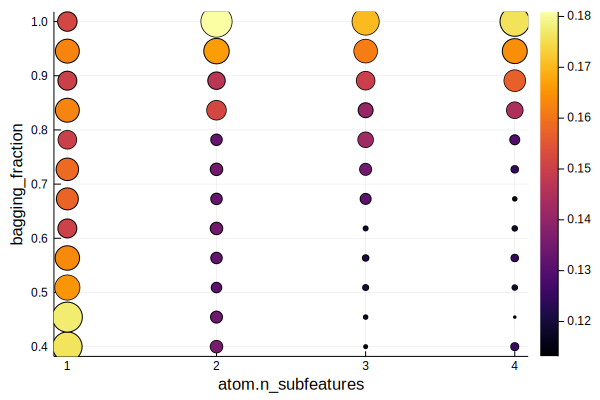

In [88]:
plot(mach)

## 3. Learning Networks

In [89]:
task = load_reduced_ames()
show(task, 1)

# SupervisedTask @ 5…70: 
X                       =>   (omitted DataFrame)
y                       =>   (omitted Vector{Float64} of length 1456)
is_probabilistic        =>   false
input_scitypes          =>   (omitted NamedTuple{(:OverallQual, :GrLivArea, :Neighborhood, :x1stFlrSF, :TotalBsmtSF, :BsmtFinSF1, :LotArea, :GarageCars, :MSSubClass, :GarageArea, :YearRemodAdd, :YearBuilt),NTuple{12,DataType}})
target                  =>   :target
input_scitype_union     =>   Union{Continuous, Multiclass{25}, Multiclass{15}}
target_scitype_union    =>   Continuous
input_is_multivariate   =>   true



In [114]:
X, y = task.X, task.y;
scitypes(X)

(OverallQual = Continuous,
 GrLivArea = Continuous,
 Neighborhood = Multiclass{25},
 x1stFlrSF = Continuous,
 TotalBsmtSF = Continuous,
 BsmtFinSF1 = Continuous,
 LotArea = Continuous,
 GarageCars = Continuous,
 MSSubClass = Multiclass{15},
 GarageArea = Continuous,
 YearRemodAdd = Continuous,
 YearBuilt = Continuous,)

In [115]:
models(task)

Dict{Any,Any} with 1 entry:
  "MLJ" => Any["MLJ.Constant.DeterministicConstantRegressor", "SmartKNN", "Blen…

## Workflow without a pipeline (static data)

In [116]:
hot = OneHotEncoder()
hotM = machine(hot, X)
fit!(hotM)
Xc = transform(hotM, X)

knn = KNNRegressor()
knnM = machine(knn, Xc, y)
fit!(knnM)
yhat = predict(knnM, Xc)
yhat[1:4]

┌ Info: Training Machine{OneHotEncoder} @ 7…47.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/machines.jl:135
┌ Info: Spawning 25 sub-features to one-hot encode feature :Neighborhood.
└ @ MLJ.Transformers /Users/anthony/.julia/packages/MLJ/y7CIQ/src/builtins/Transformers.jl:445
┌ Info: Spawning 15 sub-features to one-hot encode feature :MSSubClass.
└ @ MLJ.Transformers /Users/anthony/.julia/packages/MLJ/y7CIQ/src/builtins/Transformers.jl:445
┌ Info: Training Machine{KNNRegressor} @ 2…01.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/machines.jl:135


4-element Array{Float64,1}:
 120499.99999999994
 394432.00000000023
 177999.99999999994
 179999.99999999997

## Pipelining (dynamic data)

In [117]:
X = source(X)
y = source(y)

Source @ 4…74

Identical code to build network (`fit!`'s can be dropped)

In [118]:
hot = OneHotEncoder()
hotM = machine(hot, X)
Xc = transform(hotM, X)

knn = KNNRegressor()
knnM = machine(knn, Xc, y)
yhat = predict(knnM, Xc)

Node @ 1…29 = predict(1…53, transform(9…61, 1…84))

Fit the network in one go:

In [119]:
fit!(yhat)

┌ Info: Training NodalMachine{OneHotEncoder} @ 9…61.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/machines.jl:135
┌ Info: Spawning 25 sub-features to one-hot encode feature :Neighborhood.
└ @ MLJ.Transformers /Users/anthony/.julia/packages/MLJ/y7CIQ/src/builtins/Transformers.jl:445
┌ Info: Spawning 15 sub-features to one-hot encode feature :MSSubClass.
└ @ MLJ.Transformers /Users/anthony/.julia/packages/MLJ/y7CIQ/src/builtins/Transformers.jl:445
┌ Info: Training NodalMachine{KNNRegressor} @ 1…53.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/machines.jl:135


Node @ 1…29 = predict(1…53, transform(9…61, 1…84))

In [120]:
hot.drop_last=true

true

In [121]:
fit!(yhat)

┌ Info: Updating NodalMachine{OneHotEncoder} @ 9…61.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/machines.jl:147
┌ Info: Spawning 24 sub-features to one-hot encode feature :Neighborhood.
└ @ MLJ.Transformers /Users/anthony/.julia/packages/MLJ/y7CIQ/src/builtins/Transformers.jl:445
┌ Info: Spawning 14 sub-features to one-hot encode feature :MSSubClass.
└ @ MLJ.Transformers /Users/anthony/.julia/packages/MLJ/y7CIQ/src/builtins/Transformers.jl:445
┌ Info: Training NodalMachine{KNNRegressor} @ 1…53.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/machines.jl:135


Node @ 1…29 = predict(1…53, transform(9…61, 1…84))

In [122]:
knn.K = 7

7

In [123]:
fit!(yhat)

┌ Info: Not retraining NodalMachine{OneHotEncoder} @ 9…61.
│  It appears up-to-date. Use force=true to force retraining.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/machines.jl:141
┌ Info: Updating NodalMachine{KNNRegressor} @ 1…53.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/machines.jl:147


Node @ 1…29 = predict(1…53, transform(9…61, 1…84))

Instead of `yhat[1:4]` we have

In [124]:
yhat(rows=1:4)

4-element Array{Float64,1}:
 130843.81386332486
 332544.9587051817 
 176265.28435047154
 203767.82439615295

Or call on new data:

In [125]:
yhat(task.X)

1456-element Array{Float64,1}:
 130843.81386332486
 332544.9587051817 
 176265.28435047154
 203767.82439615295
 136978.84622897732
 131724.92769429702
 165692.5091058007 
 168885.5731044217 
 264652.80291212286
 227115.12340804684
 227608.92033231404
  96653.56535548567
 156482.38720447902
      ⋮            
 163011.92666397232
 234694.41638974738
 181699.23386663786
 174039.51818329454
 187881.6364677814 
 213099.97613132483
 154150.33752145662
 110888.20670833573
 192930.85515013785
 155675.29688294962
 168567.02190210234
 113090.15018077038

The new data is "plugged into" the orgin node, which must be unique:

In [126]:
origins(yhat) == [X,]

true

## Exporting pipeline as stand-alone model

In [127]:
comp = @from_network SmartKNN(one_hot_encoding=hot, knn_regressor=knn) <= (X, y, yhat)

SmartKNN(one_hot_encoding = OneHotEncoder @ 3…34,
         knn_regressor = KNNRegressor @ 1…06,) @ 6…25

In [130]:
params(comp)

(one_hot_encoding = (features = Symbol[],
                     drop_last = true,
                     ordered_factor = true,),
 knn_regressor = (K = 7,
                  metric = MLJ.KNN.euclidean,
                  kernel = MLJ.KNN.reciprocal,),)

In [131]:
mach = machine(comp, task)
evaluate!(mach, measure=rms)

┌ Info: Evaluating using cross-validation. 
│ nfolds=6. 
│ shuffle=false 
│ measure=MLJ.rms 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/resampling.jl:137
Cross-validating: 100%[=========================] Time: 0:00:01


6-element Array{Float64,1}:
 34686.099568861144
 39517.04545009002 
 43230.870918155924
 38603.84013977509 
 55401.90922755432 
 46238.53105076011 

## A more complicated example

In [132]:
using CategoricalArrays
x1 = rand(6);
x2 = categorical([mod(rand(Int),2) for i in 1:6]);
x3 = rand(6);
y = exp.(x1 -2x3 + 0.1*rand(6))
X = (x1=x1, x2=x2, x3=x3)

(x1 = [0.155359, 0.780243, 0.82084, 0.128182, 0.291302, 0.313772],
 x2 = CategoricalValue{Int64,UInt32}[0, 1, 0, 0, 1, 1],
 x3 = [0.822826, 0.616695, 0.596068, 0.346467, 0.369777, 0.652231],)

Here's a learning network that: (i) One-hot encodes the input table `X`; (ii)
Log transforms the continuous target `y`; (iii) Fits specified
K-nearest neighbour and ridge regressor models to the data; (iv)
Computes an average of individual model predictions; and (v) Inverse
transforms (exponentiates) the blended predictions.

In [133]:
@load RidgeRegressor

X = source(X)
y = source(y)

hot = machine(OneHotEncoder(), X)

┌ Info: A model named "RidgeRegressor" is already loaded.
│ Nothing new loaded. 
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/loading.jl:195


NodalMachine @ 1…12 = machine(OneHotEncoder @ 5…25, 1…00)

`W`, `z`, `zhat` and `yhat` are nodes in the network:

In [134]:
W = transform(hot, X) # one-hot encode the input
z = log(y) # transform the target

ridge = RidgeRegressor(lambda=0.1)
knn = KNNRegressor()

ridgeM = machine(ridge, W, z)
knnM = machine(knn, W, z)

NodalMachine @ 1…57 = machine(KNNRegressor @ 1…20, 9…10, 4…79)

Average the predictions of the KNN and ridge models:

In [135]:
zhat = 0.5*predict(ridgeM, W) + 0.5*predict(knnM, W)

Node @ 1…97 = +(#32(predict(1…62, transform(1…12, 1…00))), #32(predict(1…57, transform(1…12, 1…00))))

Inverse the target transformation:

In [136]:
yhat = exp(zhat)

Node @ 1…84 = #30(+(#32(predict(1…62, transform(1…12, 1…00))), #32(predict(1…57, transform(1…12, 1…00)))))

A tree "splat" of the learning network terminating at `yhat`:

In [137]:
MLJ.tree(yhat)

(operation = getfield(MLJ, Symbol("##30#31"))(),
 model = nothing,
 arg1 = (operation = +,
         model = nothing,
         arg1 = (operation = getfield(MLJ, Symbol("##32#33")){Float64}(0.5),
                 model = nothing,
                 arg1 = (operation = StatsBase.predict,
                         model = RidgeRegressor @ 1…00,
                         arg1 = (operation = MLJBase.transform,
                                 model = OneHotEncoder @ 5…25,
                                 arg1 = (source = Source @ 1…00,),
                                 train_arg1 = (source = Source @ 1…00,),),
                         train_arg1 = (operation = MLJBase.transform,
                                       model = OneHotEncoder @ 5…25,
                                       arg1 = (source = Source @ 1…00,),
                                       train_arg1 = (source = Source @ 1…00,),),
                         train_arg2 = (operation = getfield(MLJ, Symbol("##28#29"))(),
           

In [111]:
blend = @from_network Blen(ridge=ridge, knn=knn) <= (X, y, yhat)
blend.ridge.lambda = 0.2
mach = machine(blend, load_reduced_ames())
evaluate!(mach, measure=rms)

┌ Info: Evaluating using cross-validation. 
│ nfolds=6. 
│ shuffle=false 
│ measure=MLJ.rms 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/.julia/packages/MLJ/y7CIQ/src/resampling.jl:137
Cross-validating: 100%[=========================] Time: 0:00:01


6-element Array{Float64,1}:
 23331.522525574146
 27096.40890033297 
 30577.323636229623
 29272.855935539304
 37834.271884729416
 33413.20459176103 

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*